# Assignment 1
Submission DDL: 03.11.2024 23:59.
* For the tasks that require the text answer use *Insert* > *Text cell* and provide your answer in this cell. Text cell supports Markdown.
* Submit your work to the submission box on MyCourses. You should submit only the **.ipynb file** with your code.
* Before submission use *Runtime* > *Run all* to make sure that your notebook runs without errors.
* To download the file from Google Colab use *File* > *Download* > *Download .ipynb*.
* Submit the file with the name: A1_NAME_SURNAME_STUDENT NUMBER.ipynb

**NB! Before editing the file, save a local copy to your Google Drive, otherwise your progress will be lost**





## Task description
*wedeliver*, a food delivery company, has recently expanded to a new market with a city layout different to their homebase. The parametres for delivery time prediction, that are used in the other city, do not work well in the new location. Your task is to find the new parameters for the city and make the revenue sensitivty analysis.

The task consist of 3 parts:
* **A** – implementation of quantile regresion on test dataset (**5 points**)
* **B** – revenue general sensitivity analysis (**8 points**)
* **C** – revenue sensitivity analysis with target on specific areas (**7 points**)

Further description and specific instructions are provided within the course of the assignment. Places, where you need to write your code are commented with capital leters, e.g. #YOUR CODE HERE



In [1]:
# import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import QuantileRegressor, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

!pip install watermark

# magic methods
%matplotlib inline
%config InlineBackend.figure_format='retina' # high-resolution plots

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.2 MB/s eta 0:00:00


In [2]:
student_number = 101357283
assert type(student_number) is int, "Exclude letters, leave only numbers"

# watermark the code
%load_ext watermark
%watermark  -d -t -v -m -p numpy,pandas,sklearn,matplotlib,seaborn

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy     : 1.26.4
pandas    : 2.2.2
sklearn   : 1.5.2
matplotlib: 3.8.0
seaborn   : 0.13.2

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.1.85+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit



Next you will load the set of the previous orders, which you will use to obtain the estimates.

In [3]:
# load the train dataset from the github repo
url_train = "https://raw.githubusercontent.com/dsfb2/dsfb2-2024/main/assignment_1/data/a1_train.csv"
data_train = pd.read_csv(url_train, sep=";", index_col=0)

**The** dataset is simple, it contains only 2 columns: the delivery distance in kilometers and actual delivery time in minutes.
* **Task A1** – explore the dataset: provide the summary and visulize the data **(1 points)**

In [5]:
# YOUR CODE HERE FOR TASK A1 – SUMMARY
data_train.describe()

,distance,actual_delivery_time
count,3000.000000,3000.000000
mean,7.969326,21.338691
std,3.718042,7.369317
min,1.212815,6.774441
25%,5.192674,16.138103
50%,7.383778,20.296789
75%,9.956642,25.197016
max,27.248825,64.708509


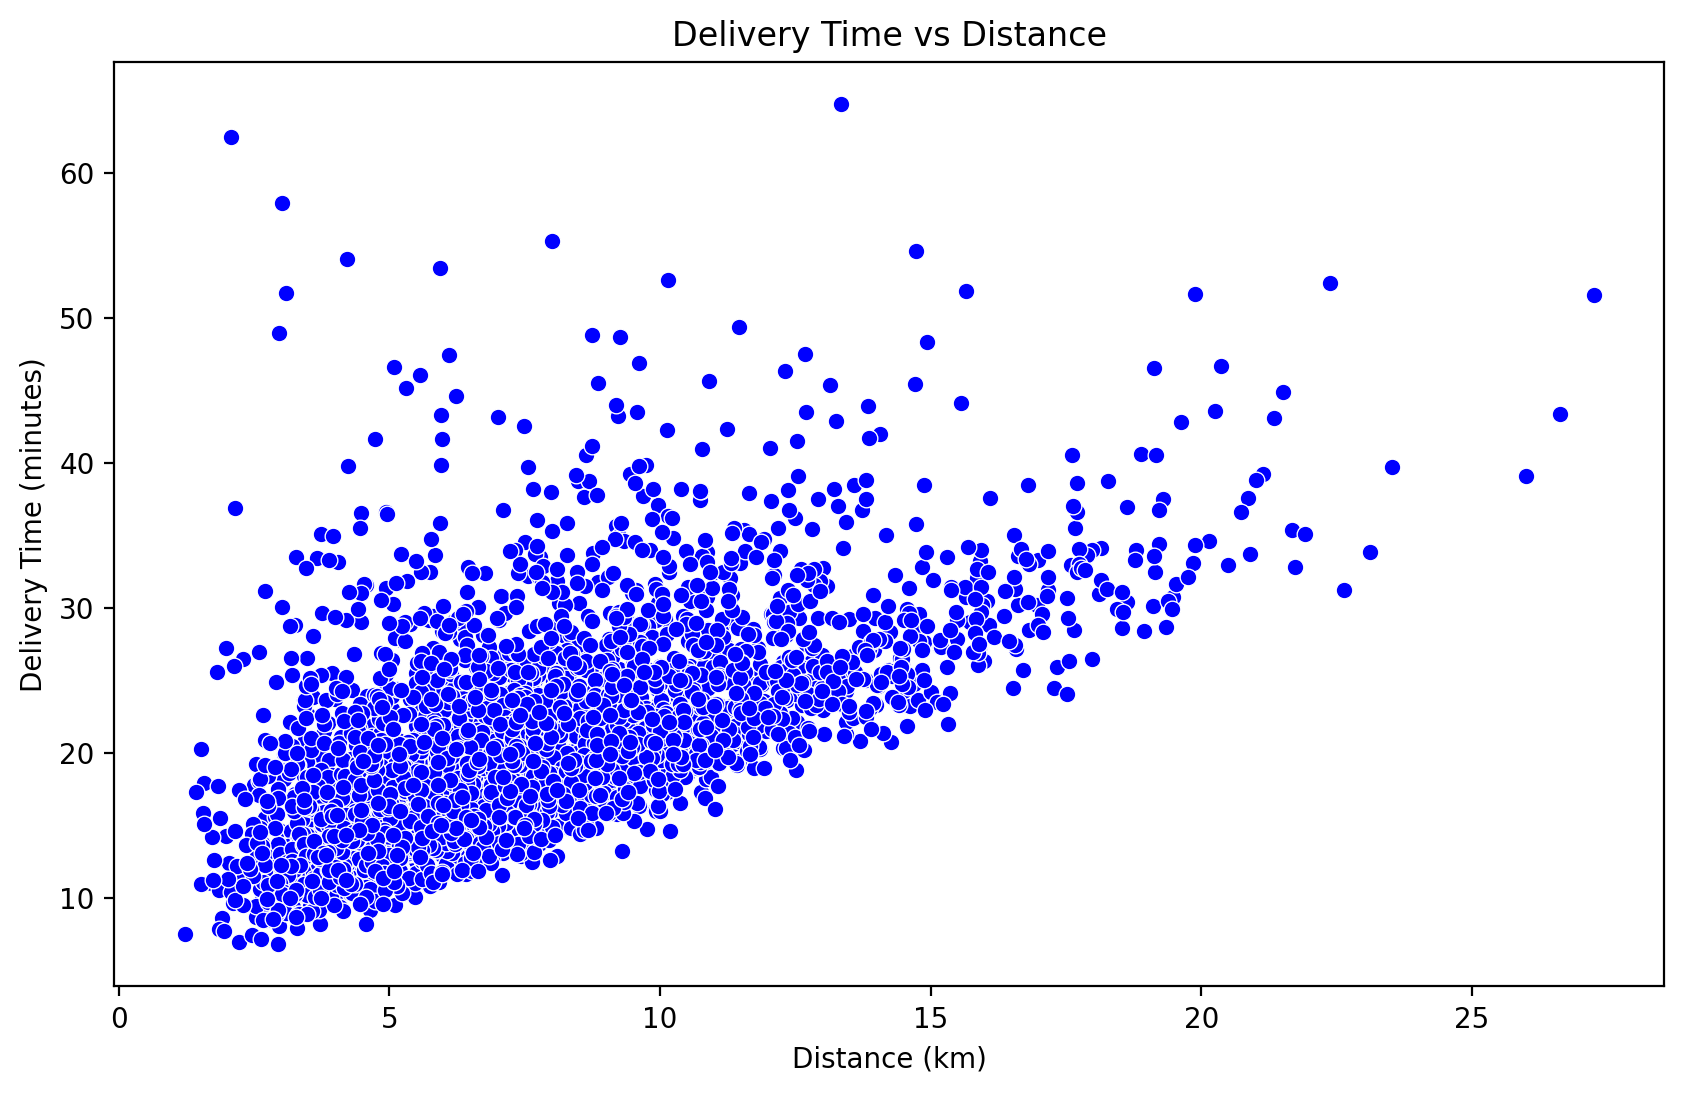

In [8]:
# YOUR CODE HERE FOR TASK A1 – VISUALIZATION
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_train, x="distance", y="actual_delivery_time", color="blue")
plt.title("Delivery Time vs Distance")
plt.xlabel("Distance (km)")
plt.ylabel("Delivery Time (minutes)")
plt.show()

# ADD A VERBAL SUMMARY OF WHAT YOU'VE LEARNT ABOUT DATA (2-3 SENTENCES) TO AN EMPTY TEXT CELL BELOW

CELL FOR A SUMMARY
The distance in the data ranges from  over 1 km to over 27 km and delivery times span from nearly 7 minutes to nearly 65 minutes. There appears to be a positive correlation between distance and delivery time, indicating that longer distances correspond to longer delivery times.

---
The interest of the company is to retain the newcoming customers. The previous analysis has shown, that customers are sensitive to the delivery time. The app, that the company provides, shows the delivery window when the order will arrive. The probability of the customer placing one more order depends on how well you've predicted the time window:
- if the order arrives early, the customer places a new order with p=0.16
- if the order arrives within 0%-25% of the time window, the customer places a new order with p=0.95
- if the order arrives within 25%-50% of the time window, the customer places a new order with p=0.9
- if the order arrives within 50%-75% of the time window, the customer places a new order with p=0.7
- if the order arrives within 75%-100% of the time window, the customer places a new order with p=0.65
- if the order arrives late, the customer places a new order with p=0.14

For example, you estimate the time windown for the order to arrive is 8 to 16 minutes
- if the order arrives in < 8 minutes, prob of a new order is 0.16
- if the order arrives in 8-10 minutes, prob of a new order is 95
- if the order arrives in 10-12 minutes, prob of a new order is 0.9
- if the order arrives in 12-14 minutes, prob of a new order is 0.7
- if the order arrives in 14-16 minutes, prob of a new order is 0.65
- if the order arrives in >16 minutes, prob of a new order is 0.14

Also customers do not like when the delivery window is too wide, so there is a penalty on the size that is reflected on the revenue.

Your aim is to figure out the time window that yields the highest revenue. The calculation is done on the test dataset, that will be introduced later.

---

At first, lets create the baseline. The company used to estimate quantile 0.3 for the lower bound of the time window and 0.8 for the upper bound of the time window.
* **Task A2** - estimate the upper and lower bound of the time window making the arrival time a linear function of the distance. For the lower bound use the 0.3 quantile, and for the upper bound use 0.8 quantile. **(4 points)**



In [4]:
# Create feature matrix

# YOUR CODE HERE
X_train = data_train["distance"].to_numpy().reshape(-1,1)
y_train = data_train["actual_delivery_time"].to_numpy()

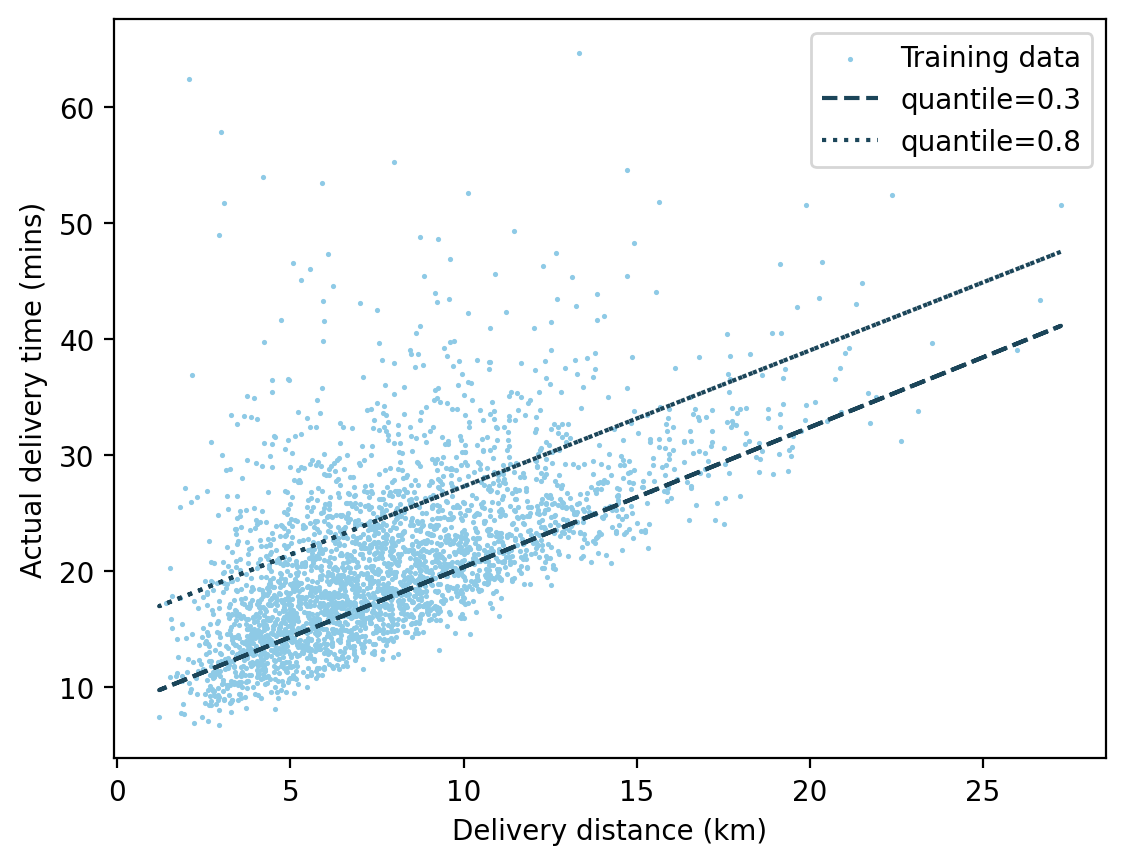

In [5]:
# Create an empty dictionary named predictions_base, where we store our results
predictions_base = {} # YOUR CODE HERE

# estimate the quantile regression for the lower bound, don't forget to use the parameter solver='highs' when you call QuantileRegressor() - it came in an update after the tutorial
lower_quantile_base = 0.3
qr_lower_base =  QuantileRegressor(quantile=lower_quantile_base, alpha=0, solver='highs') #YOUR CODE HERE
qr_lower_base.fit(X_train, y_train)
y_pred_qr_lower_base = qr_lower_base.predict(X_train)
predictions_base[lower_quantile_base] = y_pred_qr_lower_base # YOUR CODE HERE

# estimate the quantile regression for the upper bound, don't forget to use the parameter solver='highs' when you call QuantileRegressor() - it came in an update after the tutorial
upper_quantile_base = 0.8
qr_upper_base = QuantileRegressor(quantile=upper_quantile_base, alpha=0, solver='highs') # YOUR CODE HERE
qr_upper_base.fit(X_train, y_train)
y_pred_qr_upper_base = qr_upper_base.predict(X_train)
predictions_base[upper_quantile_base] = y_pred_qr_upper_base# YOUR CODE HERE

# Visualize the estimated quantiles
plt.scatter(data_train["distance"], data_train["actual_delivery_time"], color = '#8ecae6', marker = '.', s=3, label = "Training data")
plt.plot(X_train, predictions_base[lower_quantile_base], color = '#1b4559', linestyle="dashed", label = f"quantile={lower_quantile_base}")
plt.plot(X_train, predictions_base[upper_quantile_base], color = '#1b4559', linestyle="dotted", label = f"quantile={upper_quantile_base}")
plt.xlabel("Delivery distance (km)")
plt.ylabel("Actual delivery time (mins)")
plt.legend()


In [6]:
# functions to calculate the revenue
# DO NOT MODIFY THE CELL

# probability to place the next using the parameters described earlier
def prob_calc(df):
  df["stand"] = (df.actual_time-df.lower_bound) / (df.upper_bound-df.lower_bound)
  bins = [-float("inf"), 0, 0.25, 0.5, 0.75, 1,float("inf")]
  labels = [0.16, 0.95, 0.9, 0.7, 0.65, 0.14]

  df['prob'] = pd.cut(df['stand'], bins, labels=labels).astype(float)
  return df.prob

# calculate revenue based on the orders that are placed
# function takes the QuantileRegressor objects with `fit` method for lower and upper quantiles as well as the difference between the values of upper and lower quantile
def calculate_revenue(regressor_lower_quantile_fit, regressor_upper_quantile_fit, q_diff):
  url_test = "https://raw.githubusercontent.com/dsfb2/dsfb2-2024/main/assignment_1/data/a1_test.csv"
  df_test = pd.read_csv(url_test, sep=";")
  X_test = df_test["distance"].to_numpy().reshape(-1,1)
  df_test["lower_bound"] = regressor_lower_quantile_fit.predict(X_test)
  df_test["upper_bound"] = regressor_upper_quantile_fit.predict(X_test)
  df_test["prob"] = prob_calc(df_test)
  df_test["pred_order"] = df_test.prob.apply(lambda x: np.random.default_rng(seed=student_number).binomial(1, x, 1)[0])

  customer_id = 0
  df_test['new_order'] = np.nan

  for i in range(len(df_test.customer_id)):
    if df_test.loc[i, 'customer_id'] == customer_id:
      df_test.loc[i, 'new_order'] = np.minimum(df_test.loc[i, 'pred_order'], df_test.loc[i-1, 'new_order'])
    else:
      customer_id = df_test.loc[i, 'customer_id']
      df_test.loc[i, 'new_order'] = df_test.loc[i, 'pred_order']

  revenue = sum(df_test.order_value*df_test.new_order)*(1-2*q_diff/3)

  return np.around(revenue, 2)

In [7]:
# Now lets see what are the revenue based on the current time window parameters
base_revenue = calculate_revenue(qr_lower_base.fit(X_train, y_train), qr_upper_base.fit(X_train, y_train), upper_quantile_base-lower_quantile_base)
print(f'Current revenue: {base_revenue}')

Current revenue: 86879.34


You have just seen how much revenue the company earns using the old approach. The test data set used for the revenue evaluation contains information about 1000 customers who place 12000 orders. If a customer stops ordering, all future orders of this customer will not bring the company any revenue. The probability of placing the next order is based on the actual arrival time of the courier and the time window limits that you predict using the quantile regression.

NOTE: The amount of revenue may differ from your peers because the seed for the binomial distribution used to calculate whether a new order will be placed based on the probability of placement is your student number.

Now that you know the baseline, you will perform the revenue sensitivity analysis

**Task B** – conduct revenue sensitivity analysis **(8 points)**

You should explore how revenue changes as the upper and lower bounds of the time window are changed. Use different quantiles to estimate the bounds and use the `calculate_revenue()` function to calculate the revenue. Visualize the results of your analysis with the graphs of your choice. In a text cell, write a short report (about 10 sentences) on how revenue responds to the choice of quantiles. Try widening and narrowing the window and moving up and down the quantiles. Please use quantiles with a maximum precision of 2 decimal points (e.g. 0.31).

The points are distributed ias follows:
- Clarity and correcteness of code **(2 points)**
- Vizualization of results **(3 points)**
- Report of the results and discussion on revenue sensitivity  **(3 points)**

It is important that you explain the approach you take and the results you get. Even if you do not find the global optimum, it is totally fine as long as you explain what, why and how you do and what you get then.

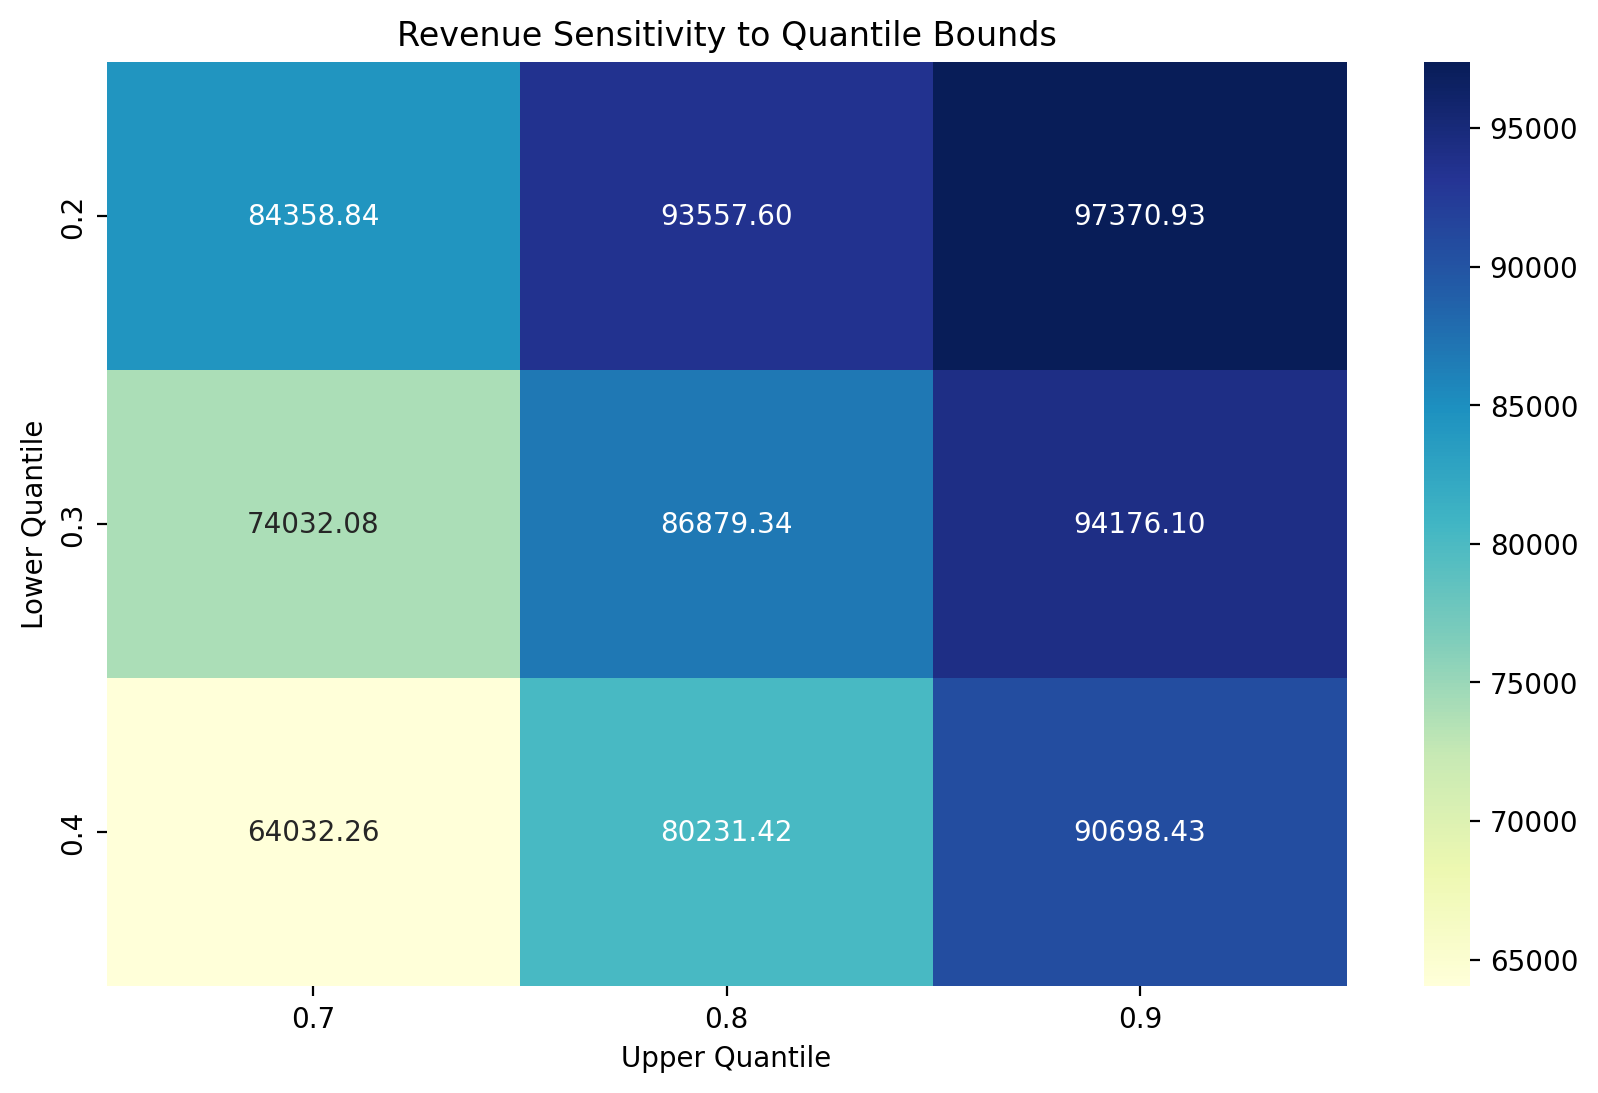

In [10]:
# YOUR CODE HERE (you can add as many cells as you need)
# Define lists of quantiles to test
lower_quantiles = [0.2, 0.3, 0.4]
upper_quantiles = [0.7, 0.8, 0.9]
revenue_results = []

# Loop over each combination of lower and upper quantiles
for lower_q in lower_quantiles:
    for upper_q in upper_quantiles:
        q_diff = upper_q - lower_q  # Calculate the window width

        # Train quantile regressors for the current pair of quantiles
        qr_lower = QuantileRegressor(quantile=lower_q, alpha=0, solver='highs').fit(X_train, y_train)
        qr_upper = QuantileRegressor(quantile=upper_q, alpha=0, solver='highs').fit(X_train, y_train)

        # Calculate revenue with the current pair of quantiles
        revenue = calculate_revenue(qr_lower, qr_upper, q_diff)
        revenue_results.append((lower_q, upper_q, revenue))

# Convert results to a DataFrame for easier visualization
df_revenue = pd.DataFrame(revenue_results, columns=['Lower Quantile', 'Upper Quantile', 'Revenue'])
df_pivot = df_revenue.pivot(index='Lower Quantile', columns='Upper Quantile', values='Revenue')

# Plotting the results to observe revenue sensitivity
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(df_pivot, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Revenue Sensitivity to Quantile Bounds")
plt.show()

CELL FOR THE REPORT
This analysis explores how revenue changes when we adjust the lower and upper quantile bounds for delivery time predictions. By setting different values for these quantiles, we effectively widen or narrow the predicted delivery time window. A larger window, which covers a broader range of delivery times, tends to allow more orders to be completed. For instance, when we use a lower quantile of 0.2 and an upper quantile of 0.9, revenue reaches its highest point, indicating that the wide time window accommodates more orders and maximizes revenue.

In contrast, when the time window is narrowed—such as with a lower quantile of 0.4 and an upper quantile of 0.7—the revenue decreases. This is likely because a narrower window restricts the acceptable delivery times, resulting in fewer orders that fall within these limits and thus reducing overall revenue. As we increase the upper quantile, revenue generally increases, which suggests that allowing longer maximum delivery times helps capture more orders. However, increasing the lower quantile often reduces revenue, as it excludes some orders with shorter delivery times.

This pattern suggests that maximizing revenue involves balancing flexibility in delivery times. A wide delivery time range helps capture a larger number of orders, while a stricter range limits the volume of orders, thus impacting revenue. So, for this model, setting a low lower quantile and a high upper quantile provides the optimal balance for maximizing revenue.

- **Task C** revenue sensitivity analysis with target on specific areas **(7 points)**

After studying the general situation, you receive input from your operations team. From their metrics, they see that the couriers tend to skip less orders with delivery distance less than 7 km and order value over 30 EUR. The team asks you to take a closer look at these customers. In your training data you do not have the order values, so you can only rely on the distance. Your task is to see if you can offer these customers a slightly different time window in order to increase their loyalty and the revenue of your company. The assignment will be scored as follows
 The task will be evaluated as follows:

- Clarity and correcteness of code **(2 points)**
- Vizualization of results **(2 points)**
- Report of the results and discussion on revenue sensitivity with treatment  **(3 points)**

Below is a new revenue calculation function. Now you need to pass the estimators for the special treatment group to the function. The report should also be about 10 sentences long.

It is important that you explain the approach you take and the results you get. Even if you do not find the global optimum, it is totally fine as long as you explain what, why and how you do and what you get then.

In [19]:
# calculate revenue based on the orders that are placed
def calculate_revenue_focus(regressor_lower_quantile_fit, regressor_upper_quantile_fit, q_diff, regressor_lower_focus, regressor_upper_focus):
  url_test = "https://raw.githubusercontent.com/dsfb2/dsfb2-2024/main/assignment_1/data/a1_test.csv"
  df_test = pd.read_csv(url_test, sep=";")
  X_test = df_test["distance"].to_numpy().reshape(-1,1)
  df_test["lower_bound_usual"] = regressor_lower_quantile_fit.predict(X_test)
  df_test["upper_bound_usual"] = regressor_upper_quantile_fit.predict(X_test)
  df_test["lower_bound_focus"] = regressor_lower_focus.predict(X_test)
  df_test["upper_bound_focus"] = regressor_upper_focus.predict(X_test)
  df_test["lower_bound"] = np.where(df_test["focus"]==1 , df_test["lower_bound_focus"] , df_test["lower_bound_usual"])
  df_test["upper_bound"] = np.where(df_test["focus"]==1 , df_test["upper_bound_focus"] , df_test["upper_bound_usual"])
  df_test["prob"] = prob_calc(df_test)
  df_test["pred_order"] = df_test.prob.apply(lambda x: np.random.default_rng(seed=student_number).binomial(1, x, 1)[0])

  customer_id = 0
  df_test['new_order'] = np.nan

  for i in range(len(df_test.customer_id)):
    if df_test.loc[i, 'customer_id'] == customer_id:
      df_test.loc[i, 'new_order'] = np.minimum(df_test.loc[i, 'pred_order'], df_test.loc[i-1, 'new_order'])
    else:
      customer_id = df_test.loc[i, 'customer_id']
      df_test.loc[i, 'new_order'] = df_test.loc[i, 'pred_order']

  revenue = sum(df_test.order_value*df_test.new_order)*(1-2*q_diff/3)

  return np.around(revenue, 2)

In [20]:
data_train['focus'] = (data_train['distance'] < 7).astype(int)

# Separate the data based on focus flag
X_focus_train = X_train[data_train['focus'] == 1]
y_focus_train = y_train[data_train['focus'] == 1]

# Step 2: Train quantile regressors for the focus group
lower_quantile_focus = 0.3
qr_lower_focus = QuantileRegressor(quantile=lower_quantile_focus, alpha=0, solver='highs')
qr_lower_focus.fit(X_focus_train, y_focus_train)

upper_quantile_focus = 0.8
qr_upper_focus = QuantileRegressor(quantile=upper_quantile_focus, alpha=0, solver='highs')
qr_upper_focus.fit(X_focus_train, y_focus_train)

# Step 3: Calculate the quantile difference for revenue calculation
q_diff = upper_quantile_base - lower_quantile_base

# Step 4: Calculate revenue for the usual group and the focus group
revenue_usual = calculate_revenue(qr_lower_base, qr_upper_base, q_diff)
revenue_focus = calculate_revenue_focus(qr_lower_base, qr_upper_base, q_diff, qr_lower_focus, qr_upper_focus)

print(f"Revenue from usual customers: {revenue_usual}")
print(f"Revenue from focus customers: {revenue_focus}")

Revenue from usual customers: 86879.34
Revenue from focus customers: 86773.46


CELL FOR THE REPORT
In this analysis, we aimed to evaluate the revenue sensitivity of our delivery service by focusing on customers with delivery distances less than 7 km. We utilized quantile regression techniques to estimate lower and upper bounds of delivery times, enabling us to understand potential revenue changes for different customer segments. The results indicated that the revenue from usual customers was approximately €86,879.34, while the revenue from the focus customers, despite their shorter distances, was slightly lower at around €86,773.46.

This marginal difference suggests that while the focus group exhibits characteristics that typically warrant greater attention, such as reduced delivery distances, their revenue contributions do not substantially exceed those of the usual customer base. This finding implies that, even with targeted approaches, merely focusing on delivery distances may not lead to significant revenue increases without additional strategies.

To enhance customer loyalty and potentially increase revenue for the focus group, we propose offering a modified time window for deliveries. This could involve providing more precise delivery estimates or introducing promotional incentives for quicker deliveries within the identified focus group. Such strategies may foster greater customer satisfaction and repeat orders, leading to improved long-term revenue.